# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions for solid Ne

In [1]:
# Load in the relevant packages

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt

LJ=bulk('Ne','fcc',a=1.55)
LJ=LJ*[2,2,2]
calc = LennardJones()
LJ.calc = calc

Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic forces. 

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [2]:
orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.02
disp_steps=5
rounds=2

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < -40: # We exclude structures that are unreasonably high in energy
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file,rattle_struc)
                print(xyz_file,file=f)
                counter += 1

f.close()
       

### Building a reference database

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S1.xyz
    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    
Any format supported by ASE can be read in.

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="LJ.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 239.37it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``LJ.db`` since the reference energies and forces are obtained from a Lennard Jones potential.

In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|███████████████████████████████████████| 40/40 [00:00<00:00, 101.91it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key. A more comprehensive guide on the fitting options can be found in Advanced_Tutorials/Search_Mode.


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonous constraints for pair:  Ne-Ne
    Merging interval for pair Ne-Ne. Number of knots reduced from 412 to 411. 


    Finding optimum switch: 100%|█████████████████████████████| 411/411 [00:52<00:00,  7.89it/s]


    The best switch is (49,) with mse: 0.0030195, corresponding to distances of [1.39] Å for element pairs ['Ne-Ne'].
    Final root mean square error in energy:  0.0005337231125796525  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performing further tests on strucutres not included in the training set is recomended but not included in the tutorial.

In [7]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

  0%|                                                                    | 0/40 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_fit_search_mode/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|███████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.26it/s]


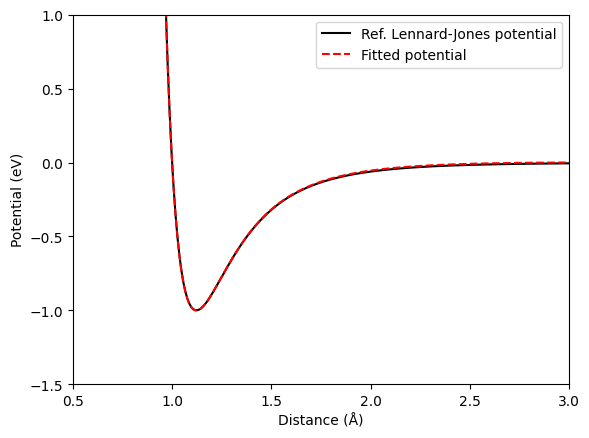

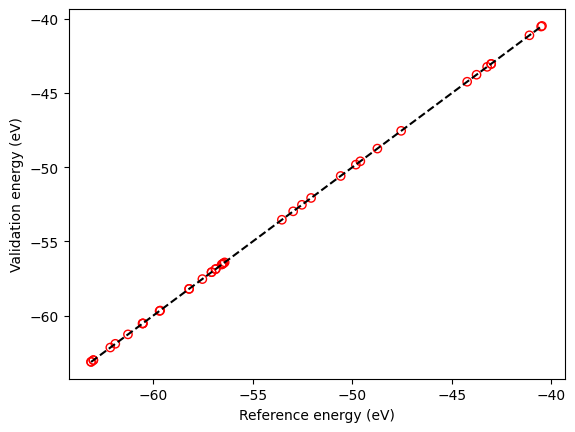

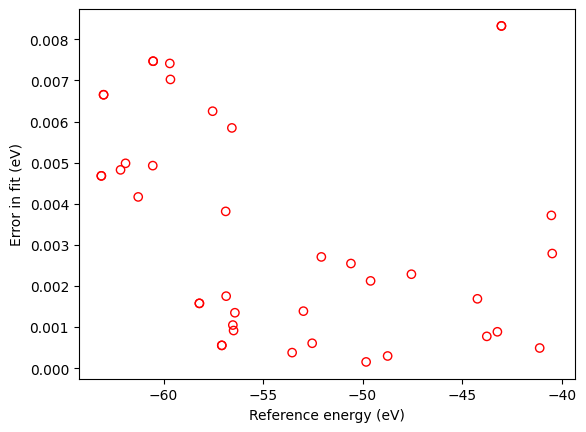

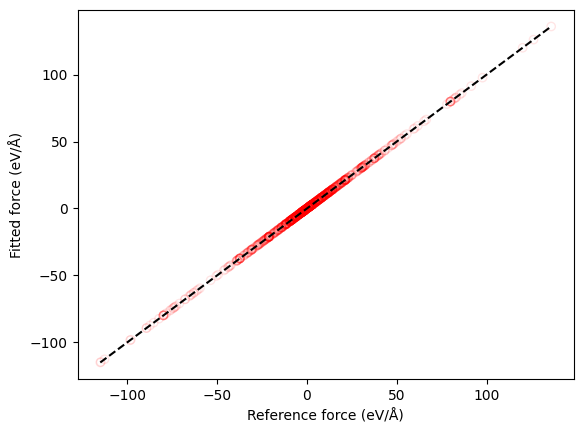

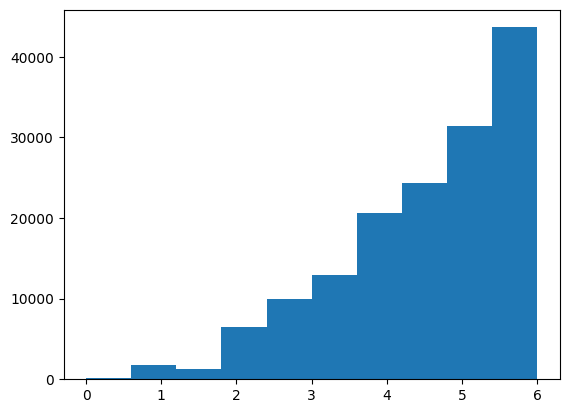

In [8]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"]["Ne-Ne"]["r"])
e=CCS_params["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

err=np.loadtxt("CCS_validate.dat")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t]["Ne-Ne"])
    
plt.hist(d)
plt.show()

### Cleaning up

In [9]:
import glob
import os

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass


list=glob.glob("CALCULATED_DATA/*")
for file in list:
    rm(file)
list=glob.glob("CCS_*")
for file in list:
    rm(file)
rm("structures.json")
rm("file_list")
rm("LJ.db")
rm("ccs.spl")